# Deep Convolutional - Realistic Image Colorization
Image colorization of grayscale to rgb directly. This is order to see the limitation of using RGB as the output when computing the loss.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image

## Import all Modules and Configure GPU

In [ ]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Debug only

## Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2023-02-20 14:31:43.537635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 14:31:43.560980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 14:31:43.561151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 14:31:43.562215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
tf.__version__

'2.9.1'

### Setup Result Directory

In [5]:
root_dir = "result/realistic_colorizing_rgb_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize=0):
        BUFFER_SIZE = 10000
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        #ds = ds.cache(filename='/tmp/RealisticColorizing', name='RealisticColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE, 256)


In [7]:
IMAGE_SIZE = (128, 128)

EPOCHS = 42

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

data_directory_path = "realistic-data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (128, 128, 3)

realistic-data-colorize: Found 97500 files
Found 163258 files belonging to 1 classes.
Number of batches 5102 of 32 elements


## Augment Data

In [8]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x,y):
    aX = trainAug(x)
    return (tf.image.rgb_to_grayscale(aX), aX)

# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)


## Present DataSet Examples

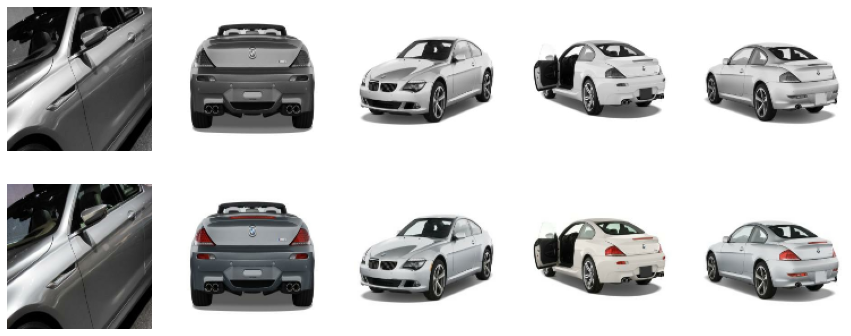

In [9]:

num_examples_to_generate = 5

bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)

plt.figure(figsize=(15, 6))
for i in range(0, num_examples_to_generate):
    ax = plt.subplot(2, num_examples_to_generate, i + 1)
    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((tf.image.rgb_to_grayscale(trainImage[:, :, :]).numpy().astype(dtype='float32') + 1.0) / 2.0, cmap='gray')
    plt.axis("off")
    ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((expectedImage[:, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
    plt.axis("off")
    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.show()


### Augmented DataSet Example

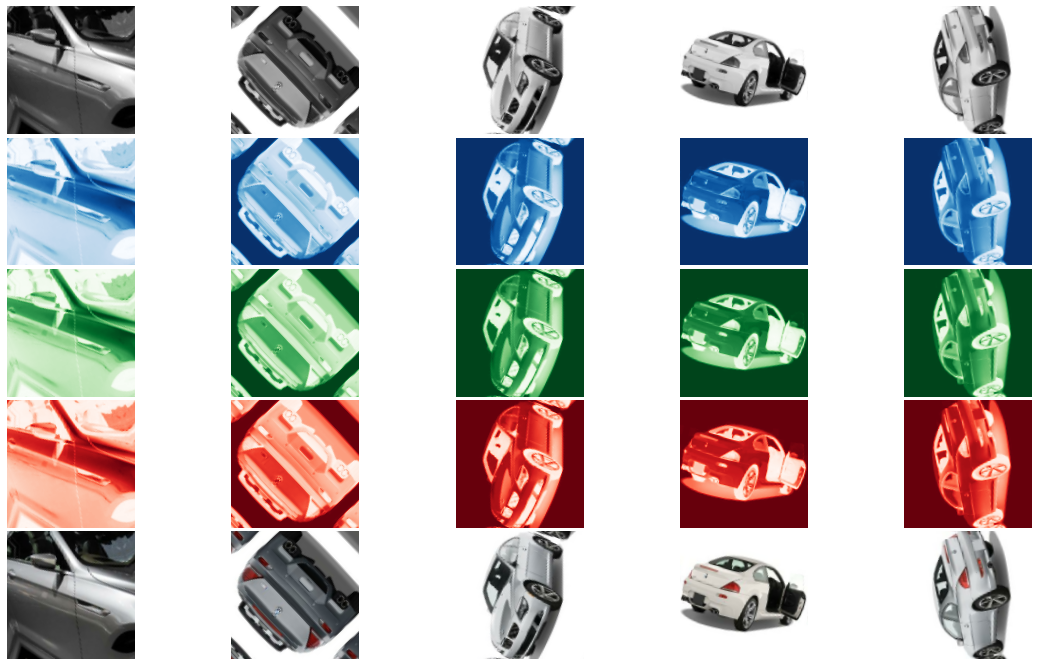

In [10]:
num_examples_to_generate = 9

bathc_iter = iter(train_ds)
image_batch, expected_batch = next(bathc_iter)

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for i in range(0, 5):

    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0

    # Transform pixel values from [-1,1] to [0,1]
    trainImage = (trainImage + 1.0) / 2.0
    expectedImage = (expectedImage + 1.0) / 2.0

    ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
    plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
    plt.imshow(expectedImage[:, :, 0].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
    plt.imshow(expectedImage[:, :, 1].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
    plt.imshow(expectedImage[:, :, 2].numpy().astype(dtype='float32'), cmap='Reds')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
    plt.imshow(expectedImage[:, :, :])
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [11]:
def create_model(hp, input_shape,image_output_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(image_output_shape[2], (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    mse_magnitude = hp.Float('mse_magnitude', 0, 1.0, step=0.1, default=0.0)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return 1.0 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + mse_magnitude * tf.keras.losses.mean_squared_error(y_true, y_pred)

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [12]:

image_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
image_output_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


def model_builder(hp):
    with strategy.scope():
        model = create_model(hp, image_input_shape, image_output_shape)
        return model


best_models = None
model = None

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='{0}/cache'.format(root_dir),
                     project_name=str.format('Colorizing - GrayScale Input - {0}', "Realistic"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(250), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project result/realistic_colorizing_rgb_color_space/cache/Colorizing - GrayScale Input - Realistic/oracle.json
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reloading Tuner from result/realistic_colorizing_rgb_color_space/cache/Colorizing - GrayScale Input - Realistic/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhos

In [13]:
def showResult(model, batchImage):
    maxNumImages = 5

    # TODO fix
    pred = (model.predict(batchImage) + 1.0) / 2.0

    train_batch_iter = iter(batchImage)
    train_image_batch, _ = next(train_batch_iter)

    predict_batch_iter = iter(pred)

    nrCol = 5
    fig = plt.figure(figsize=(maxNumImages * 4, maxNumImages*2))

    for i in range(0, 5):

        trainImage = train_image_batch[i % len(train_image_batch)]  # (images + 1.0) / 2.0
        expectedImage = next(predict_batch_iter)

        # Transform pixel values from [-1,1] to [0,1]
        trainImage = (trainImage + 1.0) / 2.0

        ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[:, :, 0].astype(dtype='float32'), cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[:, :, 1].astype(dtype='float32'), cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
        plt.imshow(expectedImage[:, :, 2].astype(dtype='float32'), cmap='Reds')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
        plt.imshow(expectedImage[:, :, :].astype(dtype='float32'))
        plt.axis("off")

        if len(train_image_batch) - 1 == i:
            train_image_batch, _ = next(train_batch_iter)
    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)

        def ColorizeFunc(x, y):
            return (tf.image.rgb_to_grayscale(x), y)

        self.trainData = trainData.map(ColorizeFunc,
                                       num_parallel_calls=tf.data.AUTOTUNE)
        # Setup to support multiple GPUs
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        self.trainData = self.trainData.with_options(options)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("{0}/realistic_coloring_rgb_colorspace_epoch_{1}.png".format(root_dir, epoch))
        plt.close()


## Train the Final Select Model

In [14]:


model_history = {}

checkpoint_path = "{0}/checkpoints/cp.ckpt".format(root_dir)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/42


2023-02-20 14:32:58.445623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-02-20 14:32:59.299574: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3958/4081 [============================>.] - ETA: 13s - loss: 0.5176 - ssim_loss: 0.5176 - accuracy: 0.4531

2023-02-20 14:40:09.941785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:10.018130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3970/4081 [============================>.] - ETA: 12s - loss: 0.5175 - ssim_loss: 0.5175 - accuracy: 0.4534

2023-02-20 14:40:11.238052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:11.238096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4009/4081 [============================>.] - ETA: 7s - loss: 0.5169 - ssim_loss: 0.5169 - accuracy: 0.4547

2023-02-20 14:40:15.487067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:15.487108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4034/4081 [============================>.] - ETA: 5s - loss: 0.5166 - ssim_loss: 0.5166 - accuracy: 0.4558

2023-02-20 14:40:18.218957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:18.218986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:18.338596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:18.338628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 14:40:18.378554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:18.378579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4059/4081 [============================>.] - ETA: 2s - loss: 0.5165 - ssim_loss: 0.5165 - accuracy: 0.4567

2023-02-20 14:40:20.961610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:20.961645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.5162 - ssim_loss: 0.5162 - accuracy: 0.4573

2023-02-20 14:40:22.514386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:40:22.514417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 460s 111ms/step - loss: 0.5162 - ssim_loss: 0.5162 - accuracy: 0.4576
Epoch 2/42
3950/4081 [============================>.] - ETA: 14s - loss: 0.3652 - ssim_loss: 0.3652 - accuracy: 0.4401

2023-02-20 14:47:43.390728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3954/4081 [============================>.] - ETA: 13s - loss: 0.3653 - ssim_loss: 0.3653 - accuracy: 0.4401

2023-02-20 14:47:43.829530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3957/4081 [============================>.] - ETA: 13s - loss: 0.3654 - ssim_loss: 0.3654 - accuracy: 0.4402

2023-02-20 14:47:44.151615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.3655 - ssim_loss: 0.3655 - accuracy: 0.4403

2023-02-20 14:47:44.584859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3994/4081 [============================>.] - ETA: 9s - loss: 0.3660 - ssim_loss: 0.3660 - accuracy: 0.4413

2023-02-20 14:47:48.174155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.3660 - ssim_loss: 0.3660 - accuracy: 0.4414

2023-02-20 14:47:48.604046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4021/4081 [============================>.] - ETA: 6s - loss: 0.3663 - ssim_loss: 0.3663 - accuracy: 0.4424

2023-02-20 14:47:51.101803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:51.205443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:51.205553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4025/4081 [============================>.] - ETA: 6s - loss: 0.3663 - ssim_loss: 0.3663 - accuracy: 0.4425

2023-02-20 14:47:51.542383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:51.641067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:51.641311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4037/4081 [============================>.] - ETA: 4s - loss: 0.3665 - ssim_loss: 0.3665 - accuracy: 0.4429

2023-02-20 14:47:52.846239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4041/4081 [============================>.] - ETA: 4s - loss: 0.3667 - ssim_loss: 0.3667 - accuracy: 0.4431

2023-02-20 14:47:53.280634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4047/4081 [============================>.] - ETA: 3s - loss: 0.3668 - ssim_loss: 0.3668 - accuracy: 0.4433

2023-02-20 14:47:53.924875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.3669 - ssim_loss: 0.3669 - accuracy: 0.4435

2023-02-20 14:47:54.359518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4066/4081 [============================>.] - ETA: 1s - loss: 0.3671 - ssim_loss: 0.3671 - accuracy: 0.4439

2023-02-20 14:47:55.934226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:56.025429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.3672 - ssim_loss: 0.3672 - accuracy: 0.4443

2023-02-20 14:47:56.820120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:47:56.877990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.3673 - ssim_loss: 0.3673 - accuracy: 0.4446
Epoch 3/42
3952/4081 [============================>.] - ETA: 14s - loss: 0.3408 - ssim_loss: 0.3408 - accuracy: 0.4367

2023-02-20 14:55:16.651914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:16.652421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3959/4081 [============================>.] - ETA: 13s - loss: 0.3409 - ssim_loss: 0.3409 - accuracy: 0.4368

2023-02-20 14:55:17.416094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:17.418881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3996/4081 [============================>.] - ETA: 9s - loss: 0.3415 - ssim_loss: 0.3415 - accuracy: 0.4379

2023-02-20 14:55:21.443821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:21.451108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4023/4081 [============================>.] - ETA: 6s - loss: 0.3419 - ssim_loss: 0.3419 - accuracy: 0.4391

2023-02-20 14:55:24.387288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:24.387468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:24.496645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:24.496733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 14:55:24.501895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:24.501941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4039/4081 [============================>.] - ETA: 4s - loss: 0.3423 - ssim_loss: 0.3423 - accuracy: 0.4397

2023-02-20 14:55:26.137650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:26.138894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4049/4081 [============================>.] - ETA: 3s - loss: 0.3424 - ssim_loss: 0.3424 - accuracy: 0.4400

2023-02-20 14:55:27.231870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:27.255253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4065/4081 [============================>.] - ETA: 1s - loss: 0.3428 - ssim_loss: 0.3428 - accuracy: 0.4406

2023-02-20 14:55:28.891444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:28.902382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4072/4081 [============================>.] - ETA: 0s - loss: 0.3428 - ssim_loss: 0.3428 - accuracy: 0.4409

2023-02-20 14:55:29.731724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 14:55:29.743251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 457s 111ms/step - loss: 0.3430 - ssim_loss: 0.3430 - accuracy: 0.4414
Epoch 4/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.3286 - ssim_loss: 0.3286 - accuracy: 0.4376

2023-02-20 15:02:54.728562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:02:54.733902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.3287 - ssim_loss: 0.3287 - accuracy: 0.4377

2023-02-20 15:02:55.498960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:02:55.504451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.3293 - ssim_loss: 0.3293 - accuracy: 0.4389

2023-02-20 15:02:59.525786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:02:59.526834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.3297 - ssim_loss: 0.3297 - accuracy: 0.4401

2023-02-20 15:03:02.471897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:02.474031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:02.570016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:02.570112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:03:02.570148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:02.570328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.3301 - ssim_loss: 0.3301 - accuracy: 0.4406

2023-02-20 15:03:04.216447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:04.221409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.3303 - ssim_loss: 0.3303 - accuracy: 0.4410

2023-02-20 15:03:05.311902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:05.320313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.3306 - ssim_loss: 0.3306 - accuracy: 0.4416

2023-02-20 15:03:06.966708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:06.976606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.3307 - ssim_loss: 0.3307 - accuracy: 0.4420

2023-02-20 15:03:07.817011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:03:07.828345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 466s 114ms/step - loss: 0.3308 - ssim_loss: 0.3308 - accuracy: 0.4423
Epoch 5/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.3200 - ssim_loss: 0.3200 - accuracy: 0.4385

2023-02-20 15:10:40.564721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:40.567170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.3202 - ssim_loss: 0.3202 - accuracy: 0.4387

2023-02-20 15:10:41.337154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:41.339871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.3208 - ssim_loss: 0.3208 - accuracy: 0.4398

2023-02-20 15:10:45.354396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:45.362663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.3211 - ssim_loss: 0.3211 - accuracy: 0.4411

2023-02-20 15:10:48.295738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:48.297032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:48.395930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:48.396082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:10:48.405654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:48.405721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4044/4081 [============================>.] - ETA: 4s - loss: 0.3215 - ssim_loss: 0.3215 - accuracy: 0.4417

2023-02-20 15:10:50.045890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:50.045988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.3218 - ssim_loss: 0.3218 - accuracy: 0.4422

2023-02-20 15:10:51.124275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:51.129872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.3220 - ssim_loss: 0.3220 - accuracy: 0.4428

2023-02-20 15:10:52.776828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:52.784627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.3221 - ssim_loss: 0.3221 - accuracy: 0.4431

2023-02-20 15:10:53.635371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:10:53.643939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 453s 111ms/step - loss: 0.3222 - ssim_loss: 0.3222 - accuracy: 0.4434
Epoch 6/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.3136 - ssim_loss: 0.3136 - accuracy: 0.4384

2023-02-20 15:18:12.668103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3958/4081 [============================>.] - ETA: 13s - loss: 0.3136 - ssim_loss: 0.3136 - accuracy: 0.4384

2023-02-20 15:18:12.879909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.3138 - ssim_loss: 0.3138 - accuracy: 0.4385

2023-02-20 15:18:13.423052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.3138 - ssim_loss: 0.3138 - accuracy: 0.4385

2023-02-20 15:18:13.640879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.3144 - ssim_loss: 0.3144 - accuracy: 0.4397

2023-02-20 15:18:17.437041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.3144 - ssim_loss: 0.3144 - accuracy: 0.4397

2023-02-20 15:18:17.655352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.3147 - ssim_loss: 0.3147 - accuracy: 0.4408

2023-02-20 15:18:20.366559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:18:20.468434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:18:20.468498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4029/4081 [============================>.] - ETA: 5s - loss: 0.3147 - ssim_loss: 0.3147 - accuracy: 0.4409

2023-02-20 15:18:20.584756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:18:20.684734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:18:20.684880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.3151 - ssim_loss: 0.3151 - accuracy: 0.4414

2023-02-20 15:18:22.106118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4045/4081 [============================>.] - ETA: 3s - loss: 0.3151 - ssim_loss: 0.3151 - accuracy: 0.4415

2023-02-20 15:18:22.318463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.3153 - ssim_loss: 0.3153 - accuracy: 0.4419

2023-02-20 15:18:23.184932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4056/4081 [============================>.] - ETA: 2s - loss: 0.3154 - ssim_loss: 0.3154 - accuracy: 0.4420

2023-02-20 15:18:23.416592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.3156 - ssim_loss: 0.3156 - accuracy: 0.4425

2023-02-20 15:18:24.831686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.3156 - ssim_loss: 0.3156 - accuracy: 0.4426

2023-02-20 15:18:25.046771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.3156 - ssim_loss: 0.3156 - accuracy: 0.4428

2023-02-20 15:18:25.677694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4078/4081 [============================>.] - ETA: 0s - loss: 0.3157 - ssim_loss: 0.3157 - accuracy: 0.4430

2023-02-20 15:18:25.897024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.3157 - ssim_loss: 0.3157 - accuracy: 0.4430
Epoch 7/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.3085 - ssim_loss: 0.3085 - accuracy: 0.4387

2023-02-20 15:25:43.508273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:43.509328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 12s - loss: 0.3086 - ssim_loss: 0.3086 - accuracy: 0.4388

2023-02-20 15:25:44.273288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:44.273439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 8s - loss: 0.3093 - ssim_loss: 0.3093 - accuracy: 0.4400

2023-02-20 15:25:48.274644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:48.274914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.3096 - ssim_loss: 0.3096 - accuracy: 0.4413

2023-02-20 15:25:51.202277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:51.203685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:51.307649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:51.307883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:25:51.312935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:51.313026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.3100 - ssim_loss: 0.3100 - accuracy: 0.4419

2023-02-20 15:25:52.939085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:52.948161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.3102 - ssim_loss: 0.3102 - accuracy: 0.4423

2023-02-20 15:25:54.026562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:54.044064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.3105 - ssim_loss: 0.3105 - accuracy: 0.4429

2023-02-20 15:25:55.668697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:55.675212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.3105 - ssim_loss: 0.3105 - accuracy: 0.4433

2023-02-20 15:25:56.519876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:25:56.534370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 450s 110ms/step - loss: 0.3107 - ssim_loss: 0.3107 - accuracy: 0.4436
Epoch 8/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.3046 - ssim_loss: 0.3046 - accuracy: 0.4380

2023-02-20 15:33:15.805971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:15.809279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.3047 - ssim_loss: 0.3047 - accuracy: 0.4382

2023-02-20 15:33:16.567835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:16.573342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.3053 - ssim_loss: 0.3053 - accuracy: 0.4394

2023-02-20 15:33:20.598748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:20.600820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.3057 - ssim_loss: 0.3057 - accuracy: 0.4406

2023-02-20 15:33:23.537003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:23.539675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:23.634576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:23.634643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:33:23.642890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:23.642954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.3060 - ssim_loss: 0.3060 - accuracy: 0.4412

2023-02-20 15:33:25.272218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:25.285736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.3063 - ssim_loss: 0.3063 - accuracy: 0.4418

2023-02-20 15:33:26.381770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:26.394237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.3065 - ssim_loss: 0.3065 - accuracy: 0.4424

2023-02-20 15:33:28.022815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:28.033635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.3066 - ssim_loss: 0.3066 - accuracy: 0.4427

2023-02-20 15:33:28.869650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:33:28.869755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 453s 111ms/step - loss: 0.3067 - ssim_loss: 0.3067 - accuracy: 0.4429
Epoch 9/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.3007 - ssim_loss: 0.3007 - accuracy: 0.4386

2023-02-20 15:40:49.076144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:49.077020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.3008 - ssim_loss: 0.3008 - accuracy: 0.4387

2023-02-20 15:40:49.834894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:49.840583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.3015 - ssim_loss: 0.3015 - accuracy: 0.4401

2023-02-20 15:40:53.848843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:53.851481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.3018 - ssim_loss: 0.3018 - accuracy: 0.4414

2023-02-20 15:40:56.776071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:56.779090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:56.880473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:56.880558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:40:56.880808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:56.881020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.3022 - ssim_loss: 0.3022 - accuracy: 0.4421

2023-02-20 15:40:58.512384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:58.515496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.3024 - ssim_loss: 0.3024 - accuracy: 0.4425

2023-02-20 15:40:59.594988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:40:59.623572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4066/4081 [============================>.] - ETA: 1s - loss: 0.3026 - ssim_loss: 0.3026 - accuracy: 0.4431

2023-02-20 15:41:01.228802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:41:01.262600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.3027 - ssim_loss: 0.3027 - accuracy: 0.4435

2023-02-20 15:41:02.093164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:41:02.093254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.3029 - ssim_loss: 0.3029 - accuracy: 0.4439
Epoch 10/42
3952/4081 [============================>.] - ETA: 14s - loss: 0.2979 - ssim_loss: 0.2979 - accuracy: 0.4375

2023-02-20 15:48:21.276044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:21.276401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3959/4081 [============================>.] - ETA: 13s - loss: 0.2980 - ssim_loss: 0.2980 - accuracy: 0.4376

2023-02-20 15:48:22.038162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:22.042607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3996/4081 [============================>.] - ETA: 9s - loss: 0.2986 - ssim_loss: 0.2986 - accuracy: 0.4389

2023-02-20 15:48:26.055838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:26.056562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4023/4081 [============================>.] - ETA: 6s - loss: 0.2990 - ssim_loss: 0.2990 - accuracy: 0.4402

2023-02-20 15:48:28.994566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:28.999250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:29.096627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:29.096693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:48:29.109867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:29.109980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4039/4081 [============================>.] - ETA: 4s - loss: 0.2993 - ssim_loss: 0.2993 - accuracy: 0.4409

2023-02-20 15:48:30.736749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:30.738314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4049/4081 [============================>.] - ETA: 3s - loss: 0.2995 - ssim_loss: 0.2995 - accuracy: 0.4412

2023-02-20 15:48:31.823981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:31.837750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4065/4081 [============================>.] - ETA: 1s - loss: 0.2998 - ssim_loss: 0.2998 - accuracy: 0.4419

2023-02-20 15:48:33.481539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:33.491194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4072/4081 [============================>.] - ETA: 0s - loss: 0.2999 - ssim_loss: 0.2999 - accuracy: 0.4423

2023-02-20 15:48:34.331981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:48:34.332089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 455s 111ms/step - loss: 0.3000 - ssim_loss: 0.3000 - accuracy: 0.4427
Epoch 11/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2955 - ssim_loss: 0.2955 - accuracy: 0.4379

2023-02-20 15:55:57.675337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:55:57.677527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2957 - ssim_loss: 0.2957 - accuracy: 0.4380

2023-02-20 15:55:58.440355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:55:58.447436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2963 - ssim_loss: 0.2963 - accuracy: 0.4393

2023-02-20 15:56:02.495997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:02.506517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2966 - ssim_loss: 0.2966 - accuracy: 0.4406

2023-02-20 15:56:05.461436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:05.466419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:05.562113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:05.562270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 15:56:05.562318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:05.562380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2970 - ssim_loss: 0.2970 - accuracy: 0.4412

2023-02-20 15:56:07.209150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:07.214174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2972 - ssim_loss: 0.2972 - accuracy: 0.4417

2023-02-20 15:56:08.310746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:08.323188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4068/4081 [============================>.] - ETA: 1s - loss: 0.2974 - ssim_loss: 0.2974 - accuracy: 0.4423

2023-02-20 15:56:09.965622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:09.978296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2975 - ssim_loss: 0.2975 - accuracy: 0.4427

2023-02-20 15:56:10.829155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 15:56:10.840300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 487s 119ms/step - loss: 0.2976 - ssim_loss: 0.2976 - accuracy: 0.4429
Epoch 12/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2935 - ssim_loss: 0.2935 - accuracy: 0.4369

2023-02-20 16:04:04.421255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:04.426915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2937 - ssim_loss: 0.2937 - accuracy: 0.4370

2023-02-20 16:04:05.189113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:05.189180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2942 - ssim_loss: 0.2942 - accuracy: 0.4383

2023-02-20 16:04:09.217130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:09.217824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2946 - ssim_loss: 0.2946 - accuracy: 0.4396

2023-02-20 16:04:12.153169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:12.155077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:12.258830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:12.259014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:04:12.275151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:12.275278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2949 - ssim_loss: 0.2949 - accuracy: 0.4402

2023-02-20 16:04:13.904507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:13.905514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2952 - ssim_loss: 0.2952 - accuracy: 0.4408

2023-02-20 16:04:14.992924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:15.005331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2954 - ssim_loss: 0.2954 - accuracy: 0.4414

2023-02-20 16:04:16.649291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:16.654834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2954 - ssim_loss: 0.2954 - accuracy: 0.4418

2023-02-20 16:04:17.501418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:04:17.517605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 454s 111ms/step - loss: 0.2956 - ssim_loss: 0.2956 - accuracy: 0.4420
Epoch 13/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2916 - ssim_loss: 0.2916 - accuracy: 0.4375

2023-02-20 16:11:38.192092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:38.195768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2918 - ssim_loss: 0.2918 - accuracy: 0.4376

2023-02-20 16:11:38.948659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:38.950620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2924 - ssim_loss: 0.2924 - accuracy: 0.4390

2023-02-20 16:11:42.976437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:42.979185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2927 - ssim_loss: 0.2927 - accuracy: 0.4403

2023-02-20 16:11:45.912697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:45.918646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:46.015914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:46.015995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:11:46.016355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:46.016459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2931 - ssim_loss: 0.2931 - accuracy: 0.4410

2023-02-20 16:11:47.656589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:47.658526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2933 - ssim_loss: 0.2933 - accuracy: 0.4415

2023-02-20 16:11:48.737003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:48.755965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2936 - ssim_loss: 0.2936 - accuracy: 0.4421

2023-02-20 16:11:50.387330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:50.404302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2936 - ssim_loss: 0.2936 - accuracy: 0.4425

2023-02-20 16:11:51.233668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:11:51.240026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 451s 110ms/step - loss: 0.2937 - ssim_loss: 0.2937 - accuracy: 0.4427
Epoch 14/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.2901 - ssim_loss: 0.2901 - accuracy: 0.4371

2023-02-20 16:19:09.489220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:09.503869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.2903 - ssim_loss: 0.2903 - accuracy: 0.4373

2023-02-20 16:19:10.248496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:10.256037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.2908 - ssim_loss: 0.2908 - accuracy: 0.4386

2023-02-20 16:19:14.275073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:14.280094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.2912 - ssim_loss: 0.2912 - accuracy: 0.4400

2023-02-20 16:19:17.210436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:17.213025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:17.311271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:17.313376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:19:17.320975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:17.321058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.2915 - ssim_loss: 0.2915 - accuracy: 0.4406

2023-02-20 16:19:18.951953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:18.952208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4052/4081 [============================>.] - ETA: 3s - loss: 0.2917 - ssim_loss: 0.2917 - accuracy: 0.4411

2023-02-20 16:19:20.043091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:20.063455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4066/4081 [============================>.] - ETA: 1s - loss: 0.2920 - ssim_loss: 0.2920 - accuracy: 0.4417

2023-02-20 16:19:21.672974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:21.696941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2921 - ssim_loss: 0.2921 - accuracy: 0.4421

2023-02-20 16:19:22.594191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:19:22.595086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.2922 - ssim_loss: 0.2922 - accuracy: 0.4424
Epoch 15/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2886 - ssim_loss: 0.2886 - accuracy: 0.4390

2023-02-20 16:26:44.652589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:44.655484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2888 - ssim_loss: 0.2888 - accuracy: 0.4392

2023-02-20 16:26:45.431036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:45.431482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2894 - ssim_loss: 0.2894 - accuracy: 0.4407

2023-02-20 16:26:49.474649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:49.479870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2897 - ssim_loss: 0.2897 - accuracy: 0.4421

2023-02-20 16:26:52.426936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:52.431664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:52.539314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:52.539427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:26:52.545625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:52.546151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2900 - ssim_loss: 0.2900 - accuracy: 0.4427

2023-02-20 16:26:54.192135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:54.193455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2903 - ssim_loss: 0.2903 - accuracy: 0.4432

2023-02-20 16:26:55.288129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:55.307028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2905 - ssim_loss: 0.2905 - accuracy: 0.4439

2023-02-20 16:26:56.960227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:56.964372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2906 - ssim_loss: 0.2906 - accuracy: 0.4443

2023-02-20 16:26:57.811031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:26:57.812123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 455s 111ms/step - loss: 0.2907 - ssim_loss: 0.2907 - accuracy: 0.4445
Epoch 16/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.2875 - ssim_loss: 0.2875 - accuracy: 0.4388

2023-02-20 16:34:21.615885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3956/4081 [============================>.] - ETA: 13s - loss: 0.2875 - ssim_loss: 0.2875 - accuracy: 0.4388

2023-02-20 16:34:21.843595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.2876 - ssim_loss: 0.2876 - accuracy: 0.4389

2023-02-20 16:34:22.383201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2876 - ssim_loss: 0.2876 - accuracy: 0.4390

2023-02-20 16:34:22.604287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.2882 - ssim_loss: 0.2882 - accuracy: 0.4404

2023-02-20 16:34:26.437437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2882 - ssim_loss: 0.2882 - accuracy: 0.4405

2023-02-20 16:34:26.656636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.2885 - ssim_loss: 0.2885 - accuracy: 0.4418

2023-02-20 16:34:29.395649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:34:29.503558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:34:29.503618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4027/4081 [============================>.] - ETA: 5s - loss: 0.2885 - ssim_loss: 0.2885 - accuracy: 0.4419

2023-02-20 16:34:29.622901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:34:29.725590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:34:29.727130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.2888 - ssim_loss: 0.2888 - accuracy: 0.4425

2023-02-20 16:34:31.157662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4043/4081 [============================>.] - ETA: 4s - loss: 0.2888 - ssim_loss: 0.2888 - accuracy: 0.4425

2023-02-20 16:34:31.373833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.2890 - ssim_loss: 0.2890 - accuracy: 0.4429

2023-02-20 16:34:32.244976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2891 - ssim_loss: 0.2891 - accuracy: 0.4430

2023-02-20 16:34:32.470152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.2893 - ssim_loss: 0.2893 - accuracy: 0.4436

2023-02-20 16:34:33.909316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2893 - ssim_loss: 0.2893 - accuracy: 0.4437

2023-02-20 16:34:34.139343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2893 - ssim_loss: 0.2893 - accuracy: 0.4440

2023-02-20 16:34:34.775788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2894 - ssim_loss: 0.2894 - accuracy: 0.4441

2023-02-20 16:34:34.997307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 462s 113ms/step - loss: 0.2895 - ssim_loss: 0.2895 - accuracy: 0.4443
Epoch 17/42
3950/4081 [============================>.] - ETA: 14s - loss: 0.2860 - ssim_loss: 0.2860 - accuracy: 0.4378

2023-02-20 16:42:00.081167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:00.100615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3957/4081 [============================>.] - ETA: 13s - loss: 0.2861 - ssim_loss: 0.2861 - accuracy: 0.4381

2023-02-20 16:42:00.849972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:00.850788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3994/4081 [============================>.] - ETA: 9s - loss: 0.2868 - ssim_loss: 0.2868 - accuracy: 0.4394

2023-02-20 16:42:04.869224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:04.874720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4021/4081 [============================>.] - ETA: 6s - loss: 0.2871 - ssim_loss: 0.2871 - accuracy: 0.4409

2023-02-20 16:42:07.808551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:07.808892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:07.905078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:07.905335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:42:07.905374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:07.905741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4037/4081 [============================>.] - ETA: 4s - loss: 0.2873 - ssim_loss: 0.2873 - accuracy: 0.4416

2023-02-20 16:42:09.549337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:09.549483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4047/4081 [============================>.] - ETA: 3s - loss: 0.2876 - ssim_loss: 0.2876 - accuracy: 0.4421

2023-02-20 16:42:10.631920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:10.639319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4063/4081 [============================>.] - ETA: 1s - loss: 0.2879 - ssim_loss: 0.2879 - accuracy: 0.4427

2023-02-20 16:42:12.277704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:12.287957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4070/4081 [============================>.] - ETA: 1s - loss: 0.2880 - ssim_loss: 0.2880 - accuracy: 0.4431

2023-02-20 16:42:13.132652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:42:13.136797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 472s 115ms/step - loss: 0.2882 - ssim_loss: 0.2882 - accuracy: 0.4436
Epoch 18/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2852 - ssim_loss: 0.2852 - accuracy: 0.4387

2023-02-20 16:49:53.202447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:49:53.204174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2854 - ssim_loss: 0.2854 - accuracy: 0.4389

2023-02-20 16:49:53.970108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:49:53.973365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2860 - ssim_loss: 0.2860 - accuracy: 0.4404

2023-02-20 16:49:58.017881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:49:58.021098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2863 - ssim_loss: 0.2863 - accuracy: 0.4418

2023-02-20 16:50:00.960808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:00.963253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:01.066660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:01.066879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:50:01.083633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:01.083790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2866 - ssim_loss: 0.2866 - accuracy: 0.4425

2023-02-20 16:50:02.718248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:02.719175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2868 - ssim_loss: 0.2868 - accuracy: 0.4430

2023-02-20 16:50:03.808503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:03.834524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2871 - ssim_loss: 0.2871 - accuracy: 0.4437

2023-02-20 16:50:05.488905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:05.497827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2871 - ssim_loss: 0.2871 - accuracy: 0.4441

2023-02-20 16:50:06.321099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:50:06.321297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 456s 111ms/step - loss: 0.2872 - ssim_loss: 0.2872 - accuracy: 0.4443
Epoch 19/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2847 - ssim_loss: 0.2847 - accuracy: 0.4391

2023-02-20 16:57:31.648673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:31.663434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2849 - ssim_loss: 0.2849 - accuracy: 0.4393

2023-02-20 16:57:32.426417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:32.427325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2855 - ssim_loss: 0.2855 - accuracy: 0.4407

2023-02-20 16:57:36.471742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:36.474637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2857 - ssim_loss: 0.2857 - accuracy: 0.4421

2023-02-20 16:57:39.423807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:39.423900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:39.527909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:39.527969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 16:57:39.527975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:39.527993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2861 - ssim_loss: 0.2861 - accuracy: 0.4428

2023-02-20 16:57:41.185279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:41.190065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2863 - ssim_loss: 0.2863 - accuracy: 0.4434

2023-02-20 16:57:42.293865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:42.300605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2866 - ssim_loss: 0.2866 - accuracy: 0.4440

2023-02-20 16:57:43.933699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:43.947895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2866 - ssim_loss: 0.2866 - accuracy: 0.4444

2023-02-20 16:57:44.785360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 16:57:44.785593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 455s 111ms/step - loss: 0.2867 - ssim_loss: 0.2867 - accuracy: 0.4446
Epoch 20/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2836 - ssim_loss: 0.2836 - accuracy: 0.4385

2023-02-20 17:05:05.654851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:05.656460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2838 - ssim_loss: 0.2838 - accuracy: 0.4387

2023-02-20 17:05:06.417306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:06.423960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2843 - ssim_loss: 0.2843 - accuracy: 0.4401

2023-02-20 17:05:10.443448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:10.448225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2846 - ssim_loss: 0.2846 - accuracy: 0.4416

2023-02-20 17:05:13.380138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:13.380898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:13.486821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:13.486904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:05:13.491951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:13.492025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2849 - ssim_loss: 0.2849 - accuracy: 0.4422

2023-02-20 17:05:15.127392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:15.129436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2851 - ssim_loss: 0.2851 - accuracy: 0.4428

2023-02-20 17:05:16.213775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:16.217701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2854 - ssim_loss: 0.2854 - accuracy: 0.4434

2023-02-20 17:05:17.868095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:17.887269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2854 - ssim_loss: 0.2854 - accuracy: 0.4438

2023-02-20 17:05:18.709300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:05:18.717019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 454s 111ms/step - loss: 0.2855 - ssim_loss: 0.2855 - accuracy: 0.4440
Epoch 21/42
3950/4081 [============================>.] - ETA: 14s - loss: 0.2827 - ssim_loss: 0.2827 - accuracy: 0.4390

2023-02-20 17:12:37.285962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3954/4081 [============================>.] - ETA: 13s - loss: 0.2828 - ssim_loss: 0.2828 - accuracy: 0.4391

2023-02-20 17:12:37.727388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3957/4081 [============================>.] - ETA: 13s - loss: 0.2828 - ssim_loss: 0.2828 - accuracy: 0.4392

2023-02-20 17:12:38.052728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.2829 - ssim_loss: 0.2829 - accuracy: 0.4393

2023-02-20 17:12:38.483849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3994/4081 [============================>.] - ETA: 9s - loss: 0.2834 - ssim_loss: 0.2834 - accuracy: 0.4405

2023-02-20 17:12:42.072902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.2835 - ssim_loss: 0.2835 - accuracy: 0.4407

2023-02-20 17:12:42.512924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4021/4081 [============================>.] - ETA: 6s - loss: 0.2837 - ssim_loss: 0.2837 - accuracy: 0.4420

2023-02-20 17:12:45.018242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:12:45.121109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:12:45.121335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4025/4081 [============================>.] - ETA: 6s - loss: 0.2838 - ssim_loss: 0.2838 - accuracy: 0.4422

2023-02-20 17:12:45.459947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:12:45.558650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:12:45.558696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4038/4081 [============================>.] - ETA: 4s - loss: 0.2840 - ssim_loss: 0.2840 - accuracy: 0.4427

2023-02-20 17:12:46.768981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4041/4081 [============================>.] - ETA: 4s - loss: 0.2841 - ssim_loss: 0.2841 - accuracy: 0.4429

2023-02-20 17:12:47.193755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4047/4081 [============================>.] - ETA: 3s - loss: 0.2842 - ssim_loss: 0.2842 - accuracy: 0.4432

2023-02-20 17:12:47.848155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4052/4081 [============================>.] - ETA: 3s - loss: 0.2843 - ssim_loss: 0.2843 - accuracy: 0.4434

2023-02-20 17:12:48.293187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4063/4081 [============================>.] - ETA: 1s - loss: 0.2845 - ssim_loss: 0.2845 - accuracy: 0.4438

2023-02-20 17:12:49.517093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.2846 - ssim_loss: 0.2846 - accuracy: 0.4440

2023-02-20 17:12:49.943174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4070/4081 [============================>.] - ETA: 1s - loss: 0.2845 - ssim_loss: 0.2845 - accuracy: 0.4442

2023-02-20 17:12:50.352258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2846 - ssim_loss: 0.2846 - accuracy: 0.4444

2023-02-20 17:12:50.783966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.2847 - ssim_loss: 0.2847 - accuracy: 0.4447
Epoch 22/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2820 - ssim_loss: 0.2820 - accuracy: 0.4391

2023-02-20 17:20:10.910244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:10.911982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2822 - ssim_loss: 0.2822 - accuracy: 0.4393

2023-02-20 17:20:11.673018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:11.680038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2827 - ssim_loss: 0.2827 - accuracy: 0.4407

2023-02-20 17:20:15.693041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:15.694626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2830 - ssim_loss: 0.2830 - accuracy: 0.4422

2023-02-20 17:20:18.623733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:18.624270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:18.724991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:18.725915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:20:18.729201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:18.729280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2833 - ssim_loss: 0.2833 - accuracy: 0.4428

2023-02-20 17:20:20.360228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:20.361423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2836 - ssim_loss: 0.2836 - accuracy: 0.4435

2023-02-20 17:20:21.458278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:21.464675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2838 - ssim_loss: 0.2838 - accuracy: 0.4441

2023-02-20 17:20:23.100660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:23.108225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2838 - ssim_loss: 0.2838 - accuracy: 0.4444

2023-02-20 17:20:23.949036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:20:23.959559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.2839 - ssim_loss: 0.2839 - accuracy: 0.4446
Epoch 23/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2811 - ssim_loss: 0.2811 - accuracy: 0.4392

2023-02-20 17:27:40.716672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:40.717217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2813 - ssim_loss: 0.2813 - accuracy: 0.4394

2023-02-20 17:27:41.472464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:41.474241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2818 - ssim_loss: 0.2818 - accuracy: 0.4409

2023-02-20 17:27:45.478450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:45.481061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2821 - ssim_loss: 0.2821 - accuracy: 0.4423

2023-02-20 17:27:48.392508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:48.399676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:48.497155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:48.497227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:27:48.502107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:48.502150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2824 - ssim_loss: 0.2824 - accuracy: 0.4430

2023-02-20 17:27:50.124067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:50.130167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2827 - ssim_loss: 0.2827 - accuracy: 0.4436

2023-02-20 17:27:51.214710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:51.218042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2829 - ssim_loss: 0.2829 - accuracy: 0.4442

2023-02-20 17:27:52.844895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:52.851308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2829 - ssim_loss: 0.2829 - accuracy: 0.4446

2023-02-20 17:27:53.691471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:27:53.696229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 450s 110ms/step - loss: 0.2830 - ssim_loss: 0.2830 - accuracy: 0.4448
Epoch 24/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2806 - ssim_loss: 0.2806 - accuracy: 0.4380

2023-02-20 17:35:09.539857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:09.541700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2807 - ssim_loss: 0.2807 - accuracy: 0.4382

2023-02-20 17:35:10.301584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:10.307709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2813 - ssim_loss: 0.2813 - accuracy: 0.4397

2023-02-20 17:35:14.303414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:14.304440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2815 - ssim_loss: 0.2815 - accuracy: 0.4412

2023-02-20 17:35:17.228689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:17.228796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:17.325480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:17.325571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:35:17.343128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:17.343229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2819 - ssim_loss: 0.2819 - accuracy: 0.4418

2023-02-20 17:35:18.957066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:18.958125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2821 - ssim_loss: 0.2821 - accuracy: 0.4423

2023-02-20 17:35:20.033859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:20.037102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2823 - ssim_loss: 0.2823 - accuracy: 0.4430

2023-02-20 17:35:21.673262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:21.691696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2824 - ssim_loss: 0.2824 - accuracy: 0.4434

2023-02-20 17:35:22.524149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:35:22.533615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 449s 110ms/step - loss: 0.2825 - ssim_loss: 0.2825 - accuracy: 0.4436
Epoch 25/42
3952/4081 [============================>.] - ETA: 13s - loss: 0.2800 - ssim_loss: 0.2800 - accuracy: 0.4380

2023-02-20 17:42:39.063837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:39.064863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3959/4081 [============================>.] - ETA: 13s - loss: 0.2801 - ssim_loss: 0.2801 - accuracy: 0.4381

2023-02-20 17:42:39.829051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:39.831622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3996/4081 [============================>.] - ETA: 9s - loss: 0.2807 - ssim_loss: 0.2807 - accuracy: 0.4396

2023-02-20 17:42:43.824812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:43.827578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4023/4081 [============================>.] - ETA: 6s - loss: 0.2810 - ssim_loss: 0.2810 - accuracy: 0.4411

2023-02-20 17:42:46.740952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:46.746409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:46.841611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:46.841682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:42:46.841695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:46.841737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4039/4081 [============================>.] - ETA: 4s - loss: 0.2813 - ssim_loss: 0.2813 - accuracy: 0.4418

2023-02-20 17:42:48.472652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:48.473342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4049/4081 [============================>.] - ETA: 3s - loss: 0.2814 - ssim_loss: 0.2814 - accuracy: 0.4421

2023-02-20 17:42:49.549281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:49.566370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4065/4081 [============================>.] - ETA: 1s - loss: 0.2818 - ssim_loss: 0.2818 - accuracy: 0.4428

2023-02-20 17:42:51.182997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:51.194567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4072/4081 [============================>.] - ETA: 0s - loss: 0.2818 - ssim_loss: 0.2818 - accuracy: 0.4432

2023-02-20 17:42:52.028670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:42:52.033017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 449s 110ms/step - loss: 0.2820 - ssim_loss: 0.2820 - accuracy: 0.4437
Epoch 26/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2794 - ssim_loss: 0.2794 - accuracy: 0.4384

2023-02-20 17:50:08.181155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:08.187854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2796 - ssim_loss: 0.2796 - accuracy: 0.4386

2023-02-20 17:50:08.937292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:08.947734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2801 - ssim_loss: 0.2801 - accuracy: 0.4401

2023-02-20 17:50:12.945456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:12.946180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2804 - ssim_loss: 0.2804 - accuracy: 0.4415

2023-02-20 17:50:15.865241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:15.870196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:15.966316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:15.966493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:50:15.979210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:15.979345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2807 - ssim_loss: 0.2807 - accuracy: 0.4422

2023-02-20 17:50:17.594425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:17.598992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2810 - ssim_loss: 0.2810 - accuracy: 0.4427

2023-02-20 17:50:18.688152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:18.698988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2812 - ssim_loss: 0.2812 - accuracy: 0.4434

2023-02-20 17:50:20.325270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:20.339652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2812 - ssim_loss: 0.2812 - accuracy: 0.4438

2023-02-20 17:50:21.167770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:50:21.168206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 449s 110ms/step - loss: 0.2814 - ssim_loss: 0.2814 - accuracy: 0.4440
Epoch 27/42
3957/4081 [============================>.] - ETA: 13s - loss: 0.2788 - ssim_loss: 0.2788 - accuracy: 0.4387

2023-02-20 17:57:41.819568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:41.820421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3964/4081 [============================>.] - ETA: 12s - loss: 0.2790 - ssim_loss: 0.2790 - accuracy: 0.4388

2023-02-20 17:57:42.587960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:42.594895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4001/4081 [============================>.] - ETA: 8s - loss: 0.2795 - ssim_loss: 0.2795 - accuracy: 0.4403

2023-02-20 17:57:46.624445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:46.626374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4028/4081 [============================>.] - ETA: 5s - loss: 0.2798 - ssim_loss: 0.2798 - accuracy: 0.4418

2023-02-20 17:57:49.580501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:49.581664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:49.680196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:49.680287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 17:57:49.685461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:49.685611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4044/4081 [============================>.] - ETA: 4s - loss: 0.2801 - ssim_loss: 0.2801 - accuracy: 0.4425

2023-02-20 17:57:51.325412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:51.328025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2804 - ssim_loss: 0.2804 - accuracy: 0.4430

2023-02-20 17:57:52.422109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:52.428190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4070/4081 [============================>.] - ETA: 1s - loss: 0.2806 - ssim_loss: 0.2806 - accuracy: 0.4437

2023-02-20 17:57:54.063714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:54.071358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4077/4081 [============================>.] - ETA: 0s - loss: 0.2807 - ssim_loss: 0.2807 - accuracy: 0.4441

2023-02-20 17:57:54.920093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 17:57:54.924910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 458s 112ms/step - loss: 0.2808 - ssim_loss: 0.2808 - accuracy: 0.4442
Epoch 28/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2784 - ssim_loss: 0.2784 - accuracy: 0.4384

2023-02-20 18:05:20.767031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:20.768279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2785 - ssim_loss: 0.2785 - accuracy: 0.4386

2023-02-20 18:05:21.536632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:21.541955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2791 - ssim_loss: 0.2791 - accuracy: 0.4401

2023-02-20 18:05:25.584750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:25.585069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2793 - ssim_loss: 0.2793 - accuracy: 0.4415

2023-02-20 18:05:28.530088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:28.537229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:28.637013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:28.637092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:05:28.637108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:28.637170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2797 - ssim_loss: 0.2797 - accuracy: 0.4421

2023-02-20 18:05:30.288269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:30.288380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2799 - ssim_loss: 0.2799 - accuracy: 0.4428

2023-02-20 18:05:31.394706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:31.400265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2801 - ssim_loss: 0.2801 - accuracy: 0.4434

2023-02-20 18:05:33.039332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:33.052927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2802 - ssim_loss: 0.2802 - accuracy: 0.4437

2023-02-20 18:05:33.900817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:05:33.901434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 476s 116ms/step - loss: 0.2803 - ssim_loss: 0.2803 - accuracy: 0.4440
Epoch 29/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.2777 - ssim_loss: 0.2777 - accuracy: 0.4377

2023-02-20 18:13:18.850469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:18.853660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 13s - loss: 0.2779 - ssim_loss: 0.2779 - accuracy: 0.4379

2023-02-20 18:13:19.618650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:19.620977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 9s - loss: 0.2784 - ssim_loss: 0.2784 - accuracy: 0.4394

2023-02-20 18:13:23.660202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:23.661142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.2787 - ssim_loss: 0.2787 - accuracy: 0.4408

2023-02-20 18:13:26.623364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:26.625261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:26.730176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:26.730286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:13:26.742230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:26.743103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.2790 - ssim_loss: 0.2790 - accuracy: 0.4415

2023-02-20 18:13:28.385697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:28.386055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.2792 - ssim_loss: 0.2792 - accuracy: 0.4420

2023-02-20 18:13:29.476145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:29.485862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.2795 - ssim_loss: 0.2795 - accuracy: 0.4427

2023-02-20 18:13:31.127788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:31.138315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2795 - ssim_loss: 0.2795 - accuracy: 0.4431

2023-02-20 18:13:31.988829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:13:31.992395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 530s 130ms/step - loss: 0.2796 - ssim_loss: 0.2796 - accuracy: 0.4434
Epoch 30/42
3958/4081 [============================>.] - ETA: 13s - loss: 0.2773 - ssim_loss: 0.2773 - accuracy: 0.4374

2023-02-20 18:22:03.645340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:03.652739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.2775 - ssim_loss: 0.2775 - accuracy: 0.4376

2023-02-20 18:22:04.411834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:04.413854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.2780 - ssim_loss: 0.2780 - accuracy: 0.4391

2023-02-20 18:22:08.400227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:08.401658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4029/4081 [============================>.] - ETA: 5s - loss: 0.2783 - ssim_loss: 0.2783 - accuracy: 0.4405

2023-02-20 18:22:11.316697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:11.318148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:11.415028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:11.415097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:22:11.415178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:11.415199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4045/4081 [============================>.] - ETA: 3s - loss: 0.2787 - ssim_loss: 0.2787 - accuracy: 0.4413

2023-02-20 18:22:13.039780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:13.041126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4055/4081 [============================>.] - ETA: 2s - loss: 0.2789 - ssim_loss: 0.2789 - accuracy: 0.4418

2023-02-20 18:22:14.123010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:14.135670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.2791 - ssim_loss: 0.2791 - accuracy: 0.4425

2023-02-20 18:22:15.789467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:15.799144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4078/4081 [============================>.] - ETA: 0s - loss: 0.2792 - ssim_loss: 0.2792 - accuracy: 0.4429

2023-02-20 18:22:16.606757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:22:16.607015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 449s 110ms/step - loss: 0.2792 - ssim_loss: 0.2792 - accuracy: 0.4430
Epoch 31/42
3954/4081 [============================>.] - ETA: 13s - loss: 0.2771 - ssim_loss: 0.2771 - accuracy: 0.4377

2023-02-20 18:29:33.328110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:33.329041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3961/4081 [============================>.] - ETA: 12s - loss: 0.2772 - ssim_loss: 0.2772 - accuracy: 0.4379

2023-02-20 18:29:34.089937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:34.097138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3998/4081 [============================>.] - ETA: 8s - loss: 0.2778 - ssim_loss: 0.2778 - accuracy: 0.4394

2023-02-20 18:29:38.088453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:38.088961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4025/4081 [============================>.] - ETA: 6s - loss: 0.2780 - ssim_loss: 0.2780 - accuracy: 0.4408

2023-02-20 18:29:41.010715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:41.010870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:41.113525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:41.113588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:29:41.120540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:41.120713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4041/4081 [============================>.] - ETA: 4s - loss: 0.2783 - ssim_loss: 0.2783 - accuracy: 0.4415

2023-02-20 18:29:42.739937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:42.740053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4051/4081 [============================>.] - ETA: 3s - loss: 0.2785 - ssim_loss: 0.2785 - accuracy: 0.4420

2023-02-20 18:29:43.814440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:43.827484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4067/4081 [============================>.] - ETA: 1s - loss: 0.2788 - ssim_loss: 0.2788 - accuracy: 0.4427

2023-02-20 18:29:45.454574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:45.478423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2789 - ssim_loss: 0.2789 - accuracy: 0.4431

2023-02-20 18:29:46.296731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:29:46.297277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 451s 110ms/step - loss: 0.2790 - ssim_loss: 0.2790 - accuracy: 0.4435
Epoch 32/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2765 - ssim_loss: 0.2765 - accuracy: 0.4376

2023-02-20 18:37:01.578616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3958/4081 [============================>.] - ETA: 13s - loss: 0.2765 - ssim_loss: 0.2765 - accuracy: 0.4376

2023-02-20 18:37:01.794068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2766 - ssim_loss: 0.2766 - accuracy: 0.4378

2023-02-20 18:37:02.332690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.2767 - ssim_loss: 0.2767 - accuracy: 0.4378

2023-02-20 18:37:02.547964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2771 - ssim_loss: 0.2771 - accuracy: 0.4393

2023-02-20 18:37:06.308215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.2772 - ssim_loss: 0.2772 - accuracy: 0.4393

2023-02-20 18:37:06.522660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2774 - ssim_loss: 0.2774 - accuracy: 0.4407

2023-02-20 18:37:09.206054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:37:09.309679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:37:09.309820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4030/4081 [============================>.] - ETA: 5s - loss: 0.2775 - ssim_loss: 0.2775 - accuracy: 0.4408

2023-02-20 18:37:09.425054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:37:09.534879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:37:09.535086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4044/4081 [============================>.] - ETA: 3s - loss: 0.2778 - ssim_loss: 0.2778 - accuracy: 0.4414

2023-02-20 18:37:10.933220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4045/4081 [============================>.] - ETA: 3s - loss: 0.2778 - ssim_loss: 0.2778 - accuracy: 0.4415

2023-02-20 18:37:11.140453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2780 - ssim_loss: 0.2780 - accuracy: 0.4419

2023-02-20 18:37:12.006534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4055/4081 [============================>.] - ETA: 2s - loss: 0.2780 - ssim_loss: 0.2780 - accuracy: 0.4420

2023-02-20 18:37:12.215583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2782 - ssim_loss: 0.2782 - accuracy: 0.4426

2023-02-20 18:37:13.631354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.2782 - ssim_loss: 0.2782 - accuracy: 0.4427

2023-02-20 18:37:13.853702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2782 - ssim_loss: 0.2782 - accuracy: 0.4430

2023-02-20 18:37:14.471389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4078/4081 [============================>.] - ETA: 0s - loss: 0.2783 - ssim_loss: 0.2783 - accuracy: 0.4431

2023-02-20 18:37:14.691171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 447s 109ms/step - loss: 0.2784 - ssim_loss: 0.2784 - accuracy: 0.4432
Epoch 33/42
3958/4081 [============================>.] - ETA: 13s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4374

2023-02-20 18:44:30.792780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:30.793045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.2762 - ssim_loss: 0.2762 - accuracy: 0.4375

2023-02-20 18:44:31.546420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:31.552674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.2767 - ssim_loss: 0.2767 - accuracy: 0.4390

2023-02-20 18:44:35.536550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:35.536913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4030/4081 [============================>.] - ETA: 5s - loss: 0.2770 - ssim_loss: 0.2770 - accuracy: 0.4406

2023-02-20 18:44:38.454932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:38.456525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:38.552296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:38.552382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:44:38.552393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:38.552483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4045/4081 [============================>.] - ETA: 3s - loss: 0.2774 - ssim_loss: 0.2774 - accuracy: 0.4412

2023-02-20 18:44:40.177845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:40.178797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4056/4081 [============================>.] - ETA: 2s - loss: 0.2776 - ssim_loss: 0.2776 - accuracy: 0.4418

2023-02-20 18:44:41.264705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:41.273453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.2778 - ssim_loss: 0.2778 - accuracy: 0.4424

2023-02-20 18:44:42.885658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:42.895298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4079/4081 [============================>.] - ETA: 0s - loss: 0.2779 - ssim_loss: 0.2779 - accuracy: 0.4429

2023-02-20 18:44:43.739194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:44:43.742537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 450s 110ms/step - loss: 0.2779 - ssim_loss: 0.2779 - accuracy: 0.4429
Epoch 34/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2758 - ssim_loss: 0.2758 - accuracy: 0.4377

2023-02-20 18:52:00.079811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:00.080341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2760 - ssim_loss: 0.2760 - accuracy: 0.4379

2023-02-20 18:52:00.835820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:00.839937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2765 - ssim_loss: 0.2765 - accuracy: 0.4394

2023-02-20 18:52:04.834804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:04.835150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2768 - ssim_loss: 0.2768 - accuracy: 0.4408

2023-02-20 18:52:07.756184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:07.758144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:07.855642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:07.855715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:52:07.855731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:07.855799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2771 - ssim_loss: 0.2771 - accuracy: 0.4415

2023-02-20 18:52:09.485998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:09.486139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4054/4081 [============================>.] - ETA: 2s - loss: 0.2773 - ssim_loss: 0.2773 - accuracy: 0.4421

2023-02-20 18:52:10.575321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:10.583442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2775 - ssim_loss: 0.2775 - accuracy: 0.4427

2023-02-20 18:52:12.211286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:12.223496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2776 - ssim_loss: 0.2776 - accuracy: 0.4431

2023-02-20 18:52:13.060388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:52:13.060517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 448s 109ms/step - loss: 0.2777 - ssim_loss: 0.2777 - accuracy: 0.4433
Epoch 35/42
3958/4081 [============================>.] - ETA: 13s - loss: 0.2755 - ssim_loss: 0.2755 - accuracy: 0.4367

2023-02-20 18:59:30.838992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:30.844620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4369

2023-02-20 18:59:31.597170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:31.598781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.2762 - ssim_loss: 0.2762 - accuracy: 0.4384

2023-02-20 18:59:35.607616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:35.610164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4029/4081 [============================>.] - ETA: 5s - loss: 0.2764 - ssim_loss: 0.2764 - accuracy: 0.4399

2023-02-20 18:59:38.524726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:38.527492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:38.625704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:38.625803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 18:59:38.625993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:38.626154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4045/4081 [============================>.] - ETA: 3s - loss: 0.2768 - ssim_loss: 0.2768 - accuracy: 0.4406

2023-02-20 18:59:40.264516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:40.265089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4056/4081 [============================>.] - ETA: 2s - loss: 0.2770 - ssim_loss: 0.2770 - accuracy: 0.4412

2023-02-20 18:59:41.357095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:41.366547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.2772 - ssim_loss: 0.2772 - accuracy: 0.4418

2023-02-20 18:59:42.991548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:43.001387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4078/4081 [============================>.] - ETA: 0s - loss: 0.2773 - ssim_loss: 0.2773 - accuracy: 0.4422

2023-02-20 18:59:43.838815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 18:59:43.839090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 450s 110ms/step - loss: 0.2773 - ssim_loss: 0.2773 - accuracy: 0.4423
Epoch 36/42
3952/4081 [============================>.] - ETA: 13s - loss: 0.2748 - ssim_loss: 0.2748 - accuracy: 0.4370

2023-02-20 19:07:01.295713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3956/4081 [============================>.] - ETA: 13s - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4371

2023-02-20 19:07:01.728807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3959/4081 [============================>.] - ETA: 13s - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4372

2023-02-20 19:07:02.057685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2750 - ssim_loss: 0.2750 - accuracy: 0.4373

2023-02-20 19:07:02.492013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3996/4081 [============================>.] - ETA: 9s - loss: 0.2755 - ssim_loss: 0.2755 - accuracy: 0.4387

2023-02-20 19:07:06.059884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4388

2023-02-20 19:07:06.493137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4023/4081 [============================>.] - ETA: 6s - loss: 0.2758 - ssim_loss: 0.2758 - accuracy: 0.4401

2023-02-20 19:07:08.989400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:07:09.090011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:07:09.090193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4028/4081 [============================>.] - ETA: 5s - loss: 0.2758 - ssim_loss: 0.2758 - accuracy: 0.4403

2023-02-20 19:07:09.430350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:07:09.526601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:07:09.526764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4039/4081 [============================>.] - ETA: 4s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4408

2023-02-20 19:07:10.728623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4043/4081 [============================>.] - ETA: 4s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4409

2023-02-20 19:07:11.159245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4050/4081 [============================>.] - ETA: 3s - loss: 0.2763 - ssim_loss: 0.2763 - accuracy: 0.4413

2023-02-20 19:07:11.818691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2764 - ssim_loss: 0.2764 - accuracy: 0.4415

2023-02-20 19:07:12.248540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4065/4081 [============================>.] - ETA: 1s - loss: 0.2766 - ssim_loss: 0.2766 - accuracy: 0.4419

2023-02-20 19:07:13.464450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2766 - ssim_loss: 0.2766 - accuracy: 0.4422

2023-02-20 19:07:13.891764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4072/4081 [============================>.] - ETA: 0s - loss: 0.2766 - ssim_loss: 0.2766 - accuracy: 0.4423

2023-02-20 19:07:14.302594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4077/4081 [============================>.] - ETA: 0s - loss: 0.2767 - ssim_loss: 0.2767 - accuracy: 0.4426

2023-02-20 19:07:14.748861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 452s 110ms/step - loss: 0.2768 - ssim_loss: 0.2768 - accuracy: 0.4428
Epoch 37/42
3952/4081 [============================>.] - ETA: 13s - loss: 0.2743 - ssim_loss: 0.2743 - accuracy: 0.4363

2023-02-20 19:14:32.526926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3956/4081 [============================>.] - ETA: 13s - loss: 0.2744 - ssim_loss: 0.2744 - accuracy: 0.4364

2023-02-20 19:14:32.963602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3959/4081 [============================>.] - ETA: 13s - loss: 0.2744 - ssim_loss: 0.2744 - accuracy: 0.4365

2023-02-20 19:14:33.288652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2745 - ssim_loss: 0.2745 - accuracy: 0.4366

2023-02-20 19:14:33.719501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3996/4081 [============================>.] - ETA: 9s - loss: 0.2750 - ssim_loss: 0.2750 - accuracy: 0.4380

2023-02-20 19:14:37.283751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2751 - ssim_loss: 0.2751 - accuracy: 0.4381

2023-02-20 19:14:37.709164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4024/4081 [============================>.] - ETA: 6s - loss: 0.2753 - ssim_loss: 0.2753 - accuracy: 0.4395

2023-02-20 19:14:40.197099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:14:40.295066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:14:40.295134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4027/4081 [============================>.] - ETA: 5s - loss: 0.2753 - ssim_loss: 0.2753 - accuracy: 0.4396

2023-02-20 19:14:40.621246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:14:40.727794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:14:40.728429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4040/4081 [============================>.] - ETA: 4s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4401

2023-02-20 19:14:41.926375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4043/4081 [============================>.] - ETA: 4s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4402

2023-02-20 19:14:42.351433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4049/4081 [============================>.] - ETA: 3s - loss: 0.2757 - ssim_loss: 0.2757 - accuracy: 0.4405

2023-02-20 19:14:42.997191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2759 - ssim_loss: 0.2759 - accuracy: 0.4408

2023-02-20 19:14:43.430185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4065/4081 [============================>.] - ETA: 1s - loss: 0.2760 - ssim_loss: 0.2760 - accuracy: 0.4412

2023-02-20 19:14:44.639179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4415

2023-02-20 19:14:45.065857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4073/4081 [============================>.] - ETA: 0s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4417

2023-02-20 19:14:45.486941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2761 - ssim_loss: 0.2761 - accuracy: 0.4418

2023-02-20 19:14:45.908329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 451s 110ms/step - loss: 0.2762 - ssim_loss: 0.2762 - accuracy: 0.4421
Epoch 38/42
3958/4081 [============================>.] - ETA: 13s - loss: 0.2742 - ssim_loss: 0.2742 - accuracy: 0.4371

2023-02-20 19:22:02.424943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:02.425247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3965/4081 [============================>.] - ETA: 12s - loss: 0.2743 - ssim_loss: 0.2743 - accuracy: 0.4373

2023-02-20 19:22:03.182312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:03.189050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4002/4081 [============================>.] - ETA: 8s - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4388

2023-02-20 19:22:07.182311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:07.182552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4029/4081 [============================>.] - ETA: 5s - loss: 0.2751 - ssim_loss: 0.2751 - accuracy: 0.4403

2023-02-20 19:22:10.089928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:10.094439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:10.191256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:10.191370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 19:22:10.200557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:10.200679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4045/4081 [============================>.] - ETA: 3s - loss: 0.2755 - ssim_loss: 0.2755 - accuracy: 0.4410

2023-02-20 19:22:11.815950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:11.819722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4055/4081 [============================>.] - ETA: 2s - loss: 0.2757 - ssim_loss: 0.2757 - accuracy: 0.4415

2023-02-20 19:22:12.892138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:12.909136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4071/4081 [============================>.] - ETA: 1s - loss: 0.2759 - ssim_loss: 0.2759 - accuracy: 0.4422

2023-02-20 19:22:14.530505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:14.544628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4078/4081 [============================>.] - ETA: 0s - loss: 0.2760 - ssim_loss: 0.2760 - accuracy: 0.4426

2023-02-20 19:22:15.373308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:22:15.382185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 450s 110ms/step - loss: 0.2760 - ssim_loss: 0.2760 - accuracy: 0.4427
Epoch 39/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2739 - ssim_loss: 0.2739 - accuracy: 0.4371

2023-02-20 19:29:32.168384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:32.169269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2740 - ssim_loss: 0.2740 - accuracy: 0.4373

2023-02-20 19:29:32.921883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:32.928372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2745 - ssim_loss: 0.2745 - accuracy: 0.4388

2023-02-20 19:29:36.909153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:36.909261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4028/4081 [============================>.] - ETA: 5s - loss: 0.2748 - ssim_loss: 0.2748 - accuracy: 0.4403

2023-02-20 19:29:39.828442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:39.828990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:39.928246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:39.930766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 19:29:39.935312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:39.935390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2751 - ssim_loss: 0.2751 - accuracy: 0.4409

2023-02-20 19:29:41.552622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:41.554943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2754 - ssim_loss: 0.2754 - accuracy: 0.4415

2023-02-20 19:29:42.627584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:42.627752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4422

2023-02-20 19:29:44.277364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:44.283750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2756 - ssim_loss: 0.2756 - accuracy: 0.4425

2023-02-20 19:29:45.120608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:29:45.123153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 449s 110ms/step - loss: 0.2757 - ssim_loss: 0.2757 - accuracy: 0.4428
Epoch 40/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2736 - ssim_loss: 0.2736 - accuracy: 0.4372

2023-02-20 19:37:00.404585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:00.405359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2738 - ssim_loss: 0.2738 - accuracy: 0.4374

2023-02-20 19:37:01.161341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:01.165113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2743 - ssim_loss: 0.2743 - accuracy: 0.4389

2023-02-20 19:37:05.134389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:05.135714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2745 - ssim_loss: 0.2745 - accuracy: 0.4404

2023-02-20 19:37:08.030291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:08.030840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:08.129105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:08.129212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 19:37:08.139862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:08.140170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2748 - ssim_loss: 0.2748 - accuracy: 0.4410

2023-02-20 19:37:09.743565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:09.751220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2751 - ssim_loss: 0.2751 - accuracy: 0.4416

2023-02-20 19:37:10.820647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:10.832579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2753 - ssim_loss: 0.2753 - accuracy: 0.4423

2023-02-20 19:37:12.452134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:12.459473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4076/4081 [============================>.] - ETA: 0s - loss: 0.2754 - ssim_loss: 0.2754 - accuracy: 0.4427

2023-02-20 19:37:13.295313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:37:13.296083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 448s 109ms/step - loss: 0.2755 - ssim_loss: 0.2755 - accuracy: 0.4429
Epoch 41/42
3961/4081 [============================>.] - ETA: 12s - loss: 0.2732 - ssim_loss: 0.2732 - accuracy: 0.4374

2023-02-20 19:44:29.015049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:29.016954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3968/4081 [============================>.] - ETA: 12s - loss: 0.2733 - ssim_loss: 0.2733 - accuracy: 0.4376

2023-02-20 19:44:29.774880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:29.775006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4005/4081 [============================>.] - ETA: 8s - loss: 0.2738 - ssim_loss: 0.2738 - accuracy: 0.4392

2023-02-20 19:44:33.752256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:33.752816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4032/4081 [============================>.] - ETA: 5s - loss: 0.2741 - ssim_loss: 0.2741 - accuracy: 0.4406

2023-02-20 19:44:36.661889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:36.663727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:36.763274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:36.763336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 19:44:36.764050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:36.764124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4048/4081 [============================>.] - ETA: 3s - loss: 0.2744 - ssim_loss: 0.2744 - accuracy: 0.4413

2023-02-20 19:44:38.380055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:38.381689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4058/4081 [============================>.] - ETA: 2s - loss: 0.2747 - ssim_loss: 0.2747 - accuracy: 0.4418

2023-02-20 19:44:39.458300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:39.468369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4074/4081 [============================>.] - ETA: 0s - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4426

2023-02-20 19:44:41.121798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:44:41.128203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 447s 109ms/step - loss: 0.2750 - ssim_loss: 0.2750 - accuracy: 0.4429
Epoch 42/42
3956/4081 [============================>.] - ETA: 13s - loss: 0.2730 - ssim_loss: 0.2730 - accuracy: 0.4368

2023-02-20 19:51:56.022180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:51:56.022593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


3963/4081 [============================>.] - ETA: 12s - loss: 0.2732 - ssim_loss: 0.2732 - accuracy: 0.4370

2023-02-20 19:51:56.774222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:51:56.782609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4000/4081 [============================>.] - ETA: 8s - loss: 0.2737 - ssim_loss: 0.2737 - accuracy: 0.4384

2023-02-20 19:52:00.760283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:00.761128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4027/4081 [============================>.] - ETA: 5s - loss: 0.2740 - ssim_loss: 0.2740 - accuracy: 0.4399

2023-02-20 19:52:03.656676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:03.662466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:03.762192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:03.763437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-02-20 19:52:03.771926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:03.772085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


4043/4081 [============================>.] - ETA: 4s - loss: 0.2743 - ssim_loss: 0.2743 - accuracy: 0.4406

2023-02-20 19:52:05.386629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:05.387966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4053/4081 [============================>.] - ETA: 3s - loss: 0.2745 - ssim_loss: 0.2745 - accuracy: 0.4411

2023-02-20 19:52:06.461034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:06.475918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4069/4081 [============================>.] - ETA: 1s - loss: 0.2748 - ssim_loss: 0.2748 - accuracy: 0.4418

2023-02-20 19:52:08.092896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:08.098423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4077/4081 [============================>.] - ETA: 0s - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4422

2023-02-20 19:52:08.945093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-02-20 19:52:08.945197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4081/4081 [==============================] - 451s 110ms/step - loss: 0.2749 - ssim_loss: 0.2749 - accuracy: 0.4424


In [15]:
model.save("{0}/dc-realistic-colorization.h5".format(root_dir))


# Image Colorization Result

1/1 [==============================] - 2s 2s/step


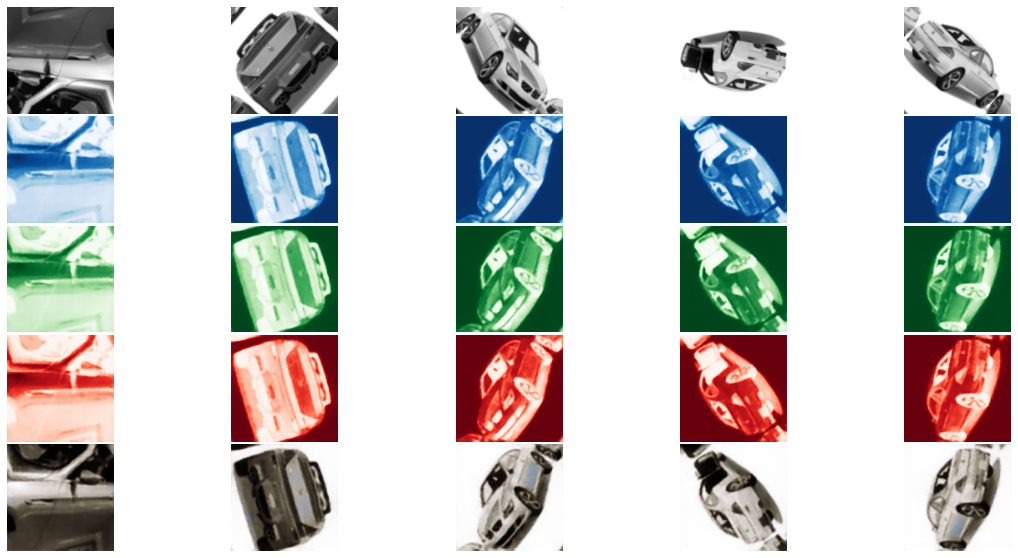

In [16]:
fig = showResult(model, train_ds.take(1))
plt.show()

In [17]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


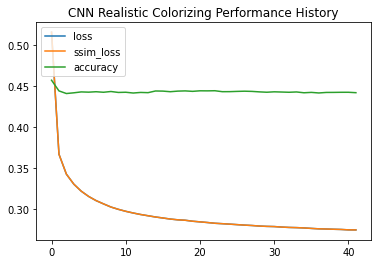

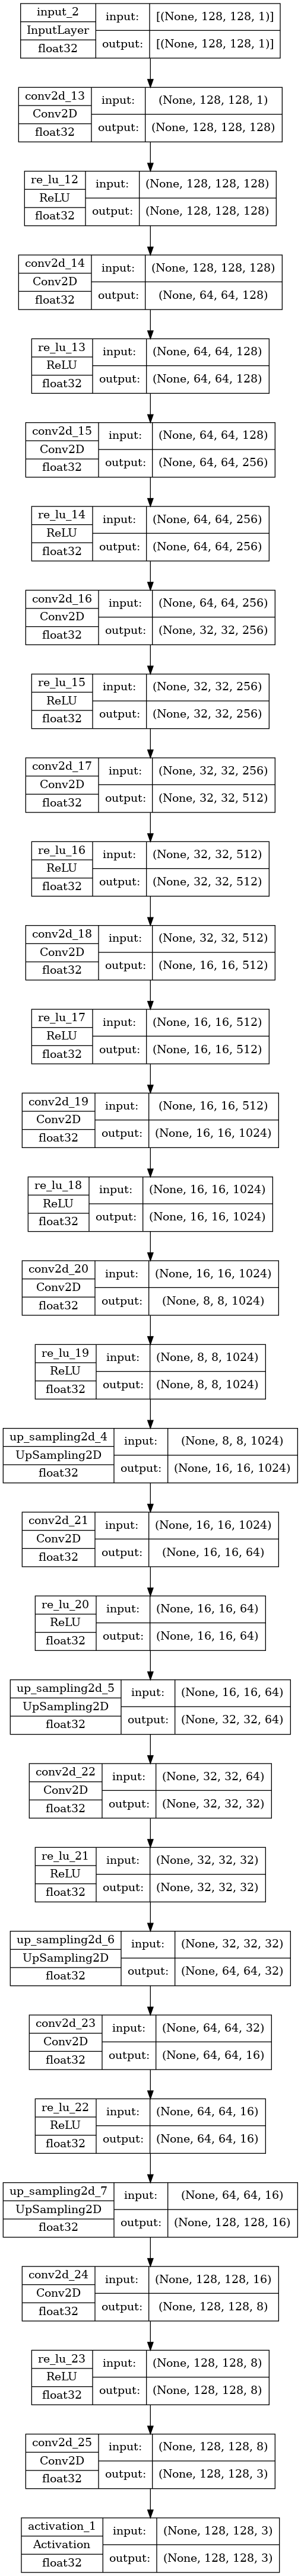

<Figure size 432x288 with 0 Axes>

In [18]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Realistic Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Realistic Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
